In [16]:
import torch
from utils.transforms import reshape_transform, flattening_transform, create_flattening_index_set
from utils.supervised_dataset import supervised_dataset as dataset

train_set_input_dir = "data/example_3_1/training_set/inputs/"
train_set_target_dir = "data/example_3_1/training_set/target_values/"
test_set_input_dir = "data/example_3_1/test_set/inputs/"
test_set_target_dir = "data/example_3_1/test_set/target_values/"
device = 'mps'
H,W = 32,32


target_transform = reshape_transform(H,W)
transform = None

train_set = dataset(
    input_dir=train_set_input_dir, 
    target_dir=train_set_target_dir, 
    transform=transform, 
    target_transform=target_transform, 
    device=device
)

test_set = dataset(
    input_dir=test_set_input_dir, 
    target_dir=test_set_target_dir, 
    transform=transform, 
    target_transform=target_transform, 
    device=device
)

x,t = test_set[1]
fn = torch.nn.Conv2d(in_channels=13,out_channels=2,kernel_size=(5,5), padding=2,dtype=torch.float32, device='mps')
fn(x).shape
x.shape


torch.Size([13, 34, 34])

In [ ]:
import torch


In [47]:
import torch
from utils.transforms import reshape_transform, flattening_transform, create_flattening_index_set
from utils.supervised_dataset import supervised_dataset as dataset

train_set_input_dir = "data/example_3_1/training_set/inputs/"
train_set_target_dir = "data/example_3_1/training_set/target_values/"
test_set_input_dir = "data/example_3_1/test_set/inputs/"
test_set_target_dir = "data/example_3_1/test_set/target_values/"
device = 'mps'
H,W = 32,32


target_transform = flattening_transform(torch.arange(H*W), 1, True)
transform = flattening_transform(create_flattening_index_set(H,W,False),13, True)

train_set = dataset(
    input_dir=train_set_input_dir, 
    target_dir=train_set_target_dir, 
    transform=transform, 
    target_transform=target_transform, 
    device=device
)

test_set = dataset(
    input_dir=test_set_input_dir, 
    target_dir=test_set_target_dir, 
    transform=transform, 
    target_transform=target_transform, 
    device=device
)

x1,t1 = test_set[1]
fn1 = torch.nn.Conv1d(in_channels=1,out_channels=1,kernel_size=1013,dtype=torch.float32, device='mps')
fn2 = torch.nn.AdaptiveMaxPool1d(3000)
print(t1.shape, fn2(x1).shape)

torch.Size([1, 1024]) torch.Size([1, 3000])


In [1]:
import torch
from utils.transforms import reshape_transform, flattening_transform, create_flattening_index_set, channeled_flattening_transform
from utils.supervised_dataset import supervised_dataset as dataset

train_set_input_dir = "data/example_3_1/training_set/inputs/"
train_set_target_dir = "data/example_3_1/training_set/target_values/"
test_set_input_dir = "data/example_3_1/test_set/inputs/"
test_set_target_dir = "data/example_3_1/test_set/target_values/"
device = 'mps'
H,W = 32,32


target_transform = flattening_transform(torch.arange(H*W), 1, True)
transform = channeled_flattening_transform(create_flattening_index_set(H+2,W+2,False),13)

train_set = dataset(
    input_dir=train_set_input_dir, 
    target_dir=train_set_target_dir, 
    transform=transform, 
    target_transform=target_transform, 
    device=device
)

test_set = dataset(
    input_dir=test_set_input_dir, 
    target_dir=test_set_target_dir, 
    transform=transform, 
    target_transform=target_transform, 
    device=device
)

x1,t1 = test_set[1]
fn1 = torch.nn.Conv1d(in_channels=13,out_channels=2,kernel_size=25, padding=12,dtype=torch.float32, device='mps')
print(fn1(x1).shape, x1.shape)

torch.Size([2, 1156]) torch.Size([13, 1156])


In [8]:
from utils.transforms import cells_from_flat_array_ind
class cnn1d(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Conv1d(in_channels=13,out_channels=9,kernel_size=9, padding=4,dtype=torch.float32, device='mps'),
            torch.nn.LeakyReLU(),
            torch.nn.Conv1d(in_channels=9,out_channels=3,kernel_size=9, padding=4,dtype=torch.float32, device='mps'),
            torch.nn.LeakyReLU(),
            torch.nn.Conv1d(in_channels=3,out_channels=1,kernel_size=9, padding=4,dtype=torch.float32, device='mps')
        )
        self.idx_key = cells_from_flat_array_ind(34,34)

    def forward(self, x):
        z = self.net(x)
        return z[:,self.idx_key+4]

model1d=cnn1d()

sum(p.numel() for p in model1d.parameters())

1336

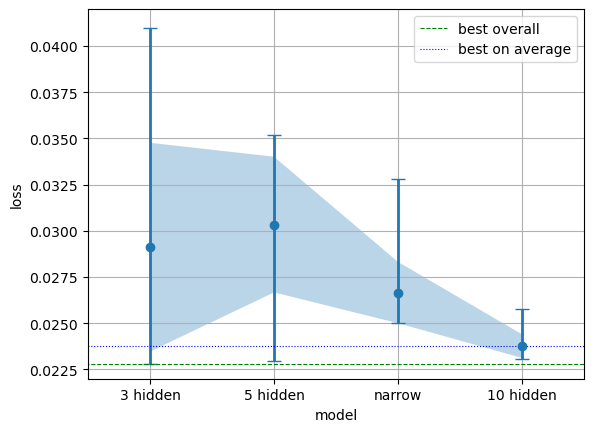

In [460]:
import numpy as np
import matplotlib.pyplot as plt

dir0 = "data/example_3_1/test_cMLP_narrow"
dir1 = "data/example_3_1/test_cMLP_3hidden"
dir2 = "data/example_3_1/test_cMLP_5hidden"
dir3 = "data/example_3_1/test_cMLP_10hidden"

dir4 = "data/example_3_2/test_loss_cnn_1d_3layers"
dir5 = "data/example_3_2/test_loss_cnn_2d_3layers"
dir6 = "data/example_3_2/test_loss_cnn_1d"
dir7 = "data/example_3_2/test_loss_cnn_2d"



def load_loss_arrays(dir, idx, threshold=None):
    l = []
    for k in idx:
        arr = np.load(f"{dir}_{k}.npy")
        if threshold:
            if np.max(arr) < threshold:
                l.append(arr)
        else:
            l.append(arr)
    return np.stack(l, axis = 0)

threshold = 2
narrow = load_loss_arrays(dir0, np.arange(50), threshold)
hidden3 = load_loss_arrays(dir1, np.arange(50), threshold)
hidden5 = load_loss_arrays(dir2, np.arange(50), threshold)
hidden10 = load_loss_arrays(dir3, np.arange(50), threshold)

avg = np.array(
    [
        np.average(np.min(hidden3, axis=1)), 
        np.average(np.min(hidden5, axis=1)),
        np.average(np.min(narrow, axis=1)), 
        np.average(np.min(hidden10, axis=1))
        ]
    )
min = np.array(
    [
        np.min(hidden3), 
        np.min(hidden5),
        np.min(narrow), 
        np.min(hidden10)
        ]
    )
max = np.array(
    [
        np.max(np.min(hidden3, axis=1)), 
        np.max(np.min(hidden5, axis=1)),
        np.max(np.min(narrow, axis=1)), 
        np.max(np.min(hidden10, axis=1))
        ]
    )

std = np.array(
    [
        np.std(np.min(hidden3, axis=1)), 
        np.std(np.min(hidden5, axis=1)),
        np.std(np.min(narrow, axis=1)), 
        np.std(np.min(hidden10, axis=1))
    ]
)
avg_err=np.vstack((avg-min,max-avg))
x=['3 hidden', '5 hidden', 'narrow',  '10 hidden']
minavg=np.min(avg)
minmin=np.min(min)
plt.errorbar(x=x, y=avg, yerr=avg_err, fmt='o', linewidth=2, capsize=5)
plt.hlines(minmin, xmin=-1, xmax=4, linestyle='--', color='green', linewidth = 0.8, label='best overall')
plt.hlines(minavg, xmin=-1, xmax=4, linestyle=':', color='blue', linewidth = 0.8, label='best on average')
plt.fill_between(x,avg-std, avg+std, alpha=0.3)

plt.xlim((-0.5,3.5))
plt.ylim(0.022,0.042)
plt.legend()
plt.xlabel('model')
plt.ylabel('loss')
plt.grid()

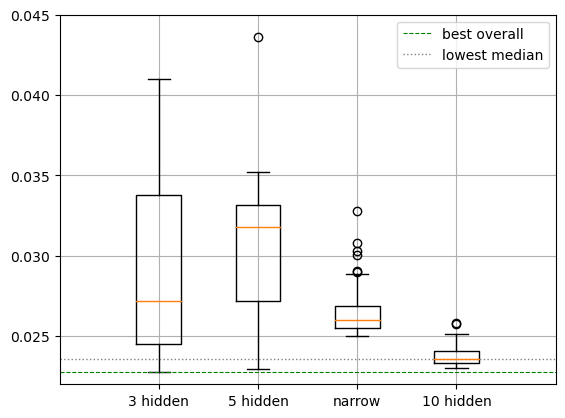

In [477]:


boxnarrow = load_loss_arrays(dir0, np.arange(50), None)
boxhidden3 = load_loss_arrays(dir1, np.arange(50), None)
boxhidden5 = load_loss_arrays(dir2, np.arange(50), None)
boxhidden10 = load_loss_arrays(dir3, np.arange(50), None)
boxavg = np.vstack(
    [
        np.min(boxhidden3, axis=1), 
        np.min(boxhidden5, axis=1),
        np.min(boxnarrow, axis=1), 
        np.min(boxhidden10, axis=1)
        ]
    )
bp = plt.boxplot(boxavg.T, labels=x)
lower_whisker_y = bp['whiskers'][0].get_ydata()[1]
lower_median = bp['medians'][3].get_ydata()[0]

plt.axhline(lower_whisker_y, linestyle='--', linewidth=0.8, color='green', label='best overall')
plt.axhline(lower_median, linestyle=':', linewidth=1, color='grey', label='lowest median')

plt.xlim((0,5))

plt.ylim(0.022,0.045)
plt.legend()
plt.grid()
plt.show()

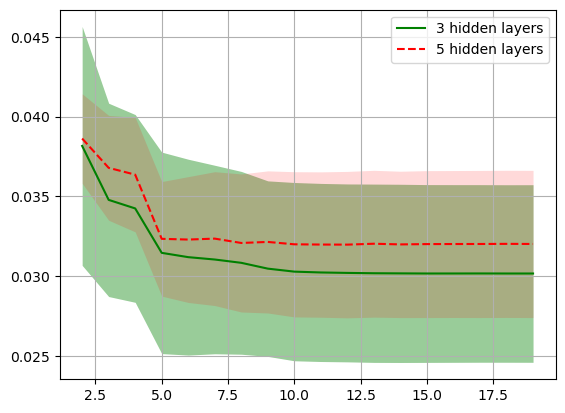

In [303]:
start = 2
end = 20
def avg_loss_plot(model, label=None, start=0, end=-1, linestyle='-', alpha=0.5, color=None, ):
    std = np.std(model, axis=0)[start:end]
    avg = np.average(model, axis=0)[start:end]
    u = avg-std
    o = avg+std

    x = np.arange(start, start+len(std))
    plt.fill_between(x, u,o, alpha=alpha,linewidth=0, color=color)
    plt.plot(x,avg, label=label,linestyle=linestyle, color=color)
#avg_loss_plot(narrow, 'narrow model', start,end, linestyle='--', alpha=0.3)
avg_loss_plot(hidden3, '3 hidden layers', start,end, alpha=0.4, color='green')
avg_loss_plot(hidden5, '5 hidden layers', start,end, alpha=0.15, linestyle='--', color='red')
#avg_loss_plot(hidden10, '10 hidden layers', start,end)
plt.legend()
plt.grid()
plt.show()

In [60]:
from IPython.display import clear_output

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn

from utils.supervised_dataset import supervised_dataset as dataset
from torch.utils.data import DataLoader
from utils.transforms import flattening_transform, reindex_transform, create_cell_ind_to_grid, create_flattening_index_set



class resblock(nn.Module):
    def __init__(self, layer):
        super().__init__()
        self.layer = layer

    def forward(self, x):
        z = self.layer(x)
        return z+x

class MLP_block(nn.Module):
    def __init__(
            self, 
            insize, 
            outsize, 
            activation, 
            normalization=None, 
            residual_connection=None, 
            Dropout=None, 
            p=0.5
        ):
        super().__init__()
        self.residual_connection = residual_connection
        components = [nn.Linear(insize, outsize), activation()]
        if normalization:
            components.append(normalization(outsize))
        if Dropout:
            components.append(nn.Dropout(p=p))
        self.layer = nn.Sequential(*components)
        if residual_connection:
            self.layer = resblock(self.layer)

            
    def forward(self, x):
        return self.layer(x) 
    
class const_featuresize_MLP(nn.Module):
    def __init__(
            self, 
            width, 
            depth, 
            activation,
            residual_connection=False, 
            normalization=False, 
            Dropout=None, 
            p=0.5
        ):
        super().__init__()
        layers = []
        for _ in range(depth-1):
            layers.append(
                MLP_block(
                    insize=width, 
                    outsize=width, 
                    activation=activation, 
                    normalization=normalization, 
                    residual_connection=residual_connection, 
                    Dropout=Dropout, 
                    p=p
                )
            )
        layers.append(
            MLP_block(
                insize=width, 
                outsize=width, 
                activation=activation, 
                normalization=None, 
                residual_connection=None, 
                Dropout=None, 
                p=p
            )
        )
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        return self.net(x)

    


class sMLP(torch.nn.Module):
    def __init__(
            self, 
            in_features, 
            cdim_MLP_width, 
            cdim_MLP_depth, 
            out_features, 
            activation, 
            residual_connection=False, 
            normalization=False, 
            Dropout=False, 
            p=0.5, 
            dir=None
        ):
        super().__init__()
        if cdim_MLP_depth == 0:
            self.ffwd = nn.Sequential(
                MLP_block(
                    insize=in_features, 
                    outsize=out_features, 
                    activation=activation, 
                )
            )
        if cdim_MLP_depth == 1:
            self.ffwd = nn.Sequential(
                MLP_block(
                    insize=in_features, 
                    outsize=out_features, 
                    activation=activation, 
                    normalization=normalization, 
                    Dropout=Dropout, 
                    p=p
                ),
                const_featuresize_MLP(
                    width=out_features, 
                    depth=1, 
                    activation=activation, 
                    residual_connection=residual_connection
                )
            )
        else:
            self.ffwd = nn.Sequential(
                MLP_block(
                    insize=in_features, 
                    outsize=cdim_MLP_width, 
                    activation=activation, 
                    normalization=normalization, 
                    Dropout=Dropout, 
                    p=p
                ),
                const_featuresize_MLP(
                    width=cdim_MLP_width, 
                    depth=cdim_MLP_depth, 
                    activation=activation, 
                    residual_connection=residual_connection, 
                    normalization=normalization, 
                    Dropout=Dropout, 
                    p=p
                ),
                MLP_block(
                    insize=cdim_MLP_width, 
                    outsize=out_features, 
                    activation=activation, 
                )
        )
        if dir:
            self.load_state_dict(torch.load(dir, weights_only=True))

    def forward(self, x):
        y_pred = self.ffwd(x)
        return y_pred



In [65]:
model = sMLP(
        in_features = 15028,
        cdim_MLP_width=2000,
        cdim_MLP_depth=10,
        out_features=1024,
        activation=torch.nn.LeakyReLU,
        residual_connection = True,
        normalization = nn.BatchNorm1d,
        Dropout = True,
        p = 0.5
)
sum(p.numel() for p in model.parameters())

72167024